# **Data Modelling and Predictions**

Sagar Patel

In the previous notebook (Data Selection) we looked into the data features of the Solar Radiation dataset and performed Explaratory Data Analysis. Now we reload that formulated data into a dataframe and look into generating a model for predicting Radiation Levels.

In [ ]:
!pip install -U -q PyDrive

# Importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import pytz
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Libraries for connecting to Google Drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

     |████████████████████████████████| 993kB 5.0MB/s 


In [ ]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
link = "https://drive.google.com/open?id=13AP4-YbCFa-GFFF0d1lEigj4YJT275a-"

fluff, id = link.split('=')
# print (id) # Verify that you have everything after '='

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('name.csv')  
data = pd.read_csv('name.csv')
# Dataset is now stored in a Pandas Dataframe

# Prepare Data
 Now that we have the data within a dataframe, lets calculate 2 new values: Day of the Year and Time of the Day (hours), and append that to our dataset.

In [ ]:
data.index =  pd.to_datetime(data['HawaiiDateTime'])
data['DayOfYear'] = data.index.strftime('%j').astype(int)
data['TimeOfDay(h)'] = data.index.hour
data.head()

,Unnamed: 0,HawaiiDateTime,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,DayTime,DayOfYear,TimeOfDay(h)
HawaiiDateTime,,,,,,,,,,,,
2016-09-01 00:00:08-10:00,0,2016-09-01 00:00:08-10:00,00:00:08,2.58,51,30.43,103,77.27,11.25,0.0,245,0
2016-09-01 00:05:10-10:00,1,2016-09-01 00:05:10-10:00,00:05:10,2.83,51,30.43,103,153.44,9.00,0.0,245,0
2016-09-01 00:20:06-10:00,2,2016-09-01 00:20:06-10:00,00:20:06,2.16,51,30.43,103,142.04,7.87,0.0,245,0
2016-09-01 00:25:05-10:00,3,2016-09-01 00:25:05-10:00,00:25:05,2.21,51,30.43,103,144.12,18.00,0.0,245,0
2016-09-01 00:30:09-10:00,4,2016-09-01 00:30:09-10:00,00:30:09,2.25,51,30.43,103,67.42,11.25,0.0,245,0


Now let us look at the correlation between the finalised attributes to understand any relations that might have been missed in the EDA.

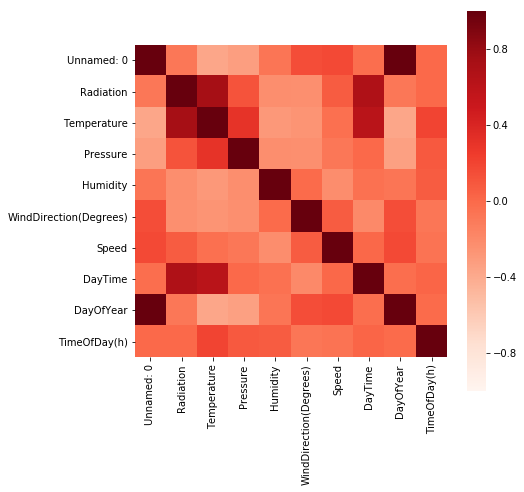

In [ ]:
# Calculate the correlation between the data attributes
correlation = data.corr()
f, ax = plt.subplots(figsize=(7,7))
ax = sns.heatmap(
    correlation, 
    vmin=-1, vmax=1, center=0,
    cmap="Reds", 
    square=True
)
plt.show()

From the correlation matrix we can see that Radiation is highly related to Temperature, where as DayTime has a considerable correlation.


# Selecting Model

As discussed in the previous notebook the suitable model for this type of data would have been a Linear Regression model. So that was implemented first and tested.

The linear regression model was able to generate a R^2 score of 61.2%. Moreover, the most important drawback for the model was that it generated negative Radiation values which we know are not possible.

Keeping that as the baseline, I moved on to implement the Decision Tree Regressor. The model worked fine in removing negative value generation, however, the model generated noise values giving an accuracy of about 50%.

Finally, to improve the model's performance Random Forest Regression was implemented. The main benefit of using this model was to handle the negative values and the provided added advantage of attribute selection. The Random Forest Regression model provided an accuracy of about 93%.

A random forest is a technique capable for performing both regression and classification. This is achieved using multiple decision trees and "Bootstrap Aggregation", a.k.a "Bagging".

This means that the model trains on a set of decsion trees generated from taking samples from the dataset. This helps the model in working on multiple decision trees samples rather than relying on a single tree and provides more confident training results.

Let us define the dependent and independent variables and then identify the best estimators for the model.

In [ ]:
X = data[['Temperature', 
          'Pressure', 
          'Humidity',
          'WindDirection(Degrees)', 
          'Speed', 
          'DayTime', 
          'DayOfYear', 
          'TimeOfDay(h)']]

y = data['Radiation']

Split the data into test and train (20% - 80% ratio).

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2,
                                                    random_state = 0)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
regressor = RandomForestRegressor(n_estimators = 100)
regressor.fit(X_train, y_train)
feature_importances = regressor.feature_importances_

X_train_opt = X_train.copy()
removed_columns = pd.DataFrame()
models = []
r2s_opt = []

for i in range(0,5):
    least_important = np.argmin(feature_importances)
    removed_columns = removed_columns.append(
        X_train_opt.pop(X_train_opt.columns[least_important]))
    regressor.fit(X_train_opt, y_train)
    feature_importances = regressor.feature_importances_
    accuracies = cross_val_score(estimator = regressor,
                                 X = X_train_opt,
                                 y = y_train, cv = 5,
                                 scoring = 'r2')
    r2s_opt = np.append(r2s_opt, accuracies.mean())
    models = np.append(models, ", ".join(list(X_train_opt)))
    
feature_selection = pd.DataFrame({'Features':models,'r2 Score':r2s_opt})
feature_selection.head()

,Features,r2 Score
0,"Temperature, Pressure, Humidity, WindDirection...",0.925123
1,"Temperature, Humidity, WindDirection(Degrees),...",0.922924
2,"Temperature, Humidity, DayTime, DayOfYear, Tim...",0.924210
3,"Temperature, DayTime, DayOfYear, TimeOfDay(h)",0.926225
4,"Temperature, DayTime, TimeOfDay(h)",0.842813


From the above table, we can observe that the (Temperature, DayTime, DayOfYear and TimeOfDay(h)) value combination provides the best possible r2 score of around 92%.

So using that, lets fit the model.

In [ ]:
X_train_best = X_train[['Temperature',
                        'DayTime', 
                        'DayOfYear', 
                        'TimeOfDay(h)']]

X_test_best = X_test[['Temperature',
                      'DayTime', 
                      'DayOfYear', 
                      'TimeOfDay(h)']]

regressor.fit(X_train_best, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

To verify the accuracy of the model, we use the Cross validation score estimator with 10 folds. It supports the accuracy of the model to 92%.

In [ ]:
accuracies = cross_val_score(estimator = regressor, 
                             X = X_train_best,
                             y = y_train, 
                             cv = 10, 
                             scoring = 'r2')
accuracy = accuracies.mean()
print('Accuracy = {}'.format(accuracy))

Accuracy = 0.9268655912240129


Let us also calculate other statistical values from the model such as the mean square error and explained variance score of the model.

In [ ]:
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
y_pred = regressor.predict(X_test_best)
explained_variance_score = explained_variance_score(y_test, y_pred)
mean_squared_error = mean_squared_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)
print('explained variance = {}'.format(explained_variance_score))
print('mse = {}'.format(mean_squared_error))
print('r2 = {}'.format(r_squared))

explained variance = 0.9326733735244472
mse = 6942.918273573292
r2 = 0.9326453513111753


To plot the performace of the model, I predict the radiaiton levels for the complete dataset and then generate a visualization to map the prediciton and original radiation values.

In [ ]:
#  Predicting for whole dataset
data['y_pred'] = regressor.predict(data[['Temperature',
                                         'DayTime',
                                         'DayOfYear',
                                         'TimeOfDay(h)']])

# Create Interactive Plot Using Bokeh
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import Range1d
output_notebook() 

p = figure(plot_width=800, 
           plot_height=400,
           title="Solar Irradiance Predictions",
           x_axis_label='Date and Time',
           y_axis_label='Solar Irradiance',
           x_axis_type="datetime")
p.x_range = Range1d(data.index[0], data.index[600])
p.y_range = Range1d(-100, 1800, bounds=(-100, 1800))
p.line(data.index, data['Radiation'], legend='Observed Solar Irradiance', 
       line_width=1)
p.line(data.index, data['y_pred'], legend='Predicted Solar Irradiance', 
       line_width=1, line_color="red")

show(p, notebook_handle = True)

As we can see in the graph, the predicted values closely follow the original radiation levels. The plot is interactive and thus can be manuevered around to observe the informaiton in more detail.

# Discussion
Now that we have a model to predict the radiation levels, let us analyze the results.

From our initial predictions, we can see that the model provides us with a confidence level of around 92% (r2 score). But as the model was trainied using only 4 months of data from a particular year, expecting it to predict values for other years or months outside the training sample dataset is not advisable.

The model is not capable of handling outliers and mischellaneous values but to make it more reliable, the training data can be expanded to cover multiple years.

Let us perform a little test of our own by defining two sets of data: Interpolated and Extrapolated, based on the provided source dataset and verify the accuracy of the model.

In [ ]:
data_interpolation = {'Temperature':[62.00, 50.00, 60.00, 52.00, 61.00],
        'DayTime':[1.00,0.00, 1.00, 0.00, 1.00],
        'DayOfYear':[250.00, 325.00, 305.00, 280.00, 350.00],
        'TimeOfDay(h)':[12.00, 4.00, 10.00, 6.00, 13.00]}

interpolationDataSet_manual = pd.DataFrame(data_interpolation)
interpolation_manual_test = [1065.30, 1.71, 1023.12, 2.03, 1040.50]

In [ ]:
interpolation_pred = regressor.predict(interpolationDataSet_manual)
r_squared = r2_score(interpolation_manual_test, interpolation_pred)
print('r2 = {}'.format(r_squared))

accuracies_interpolation = cross_val_score(estimator = regressor, 
                                           X = interpolationDataSet_manual,
                                           y = interpolation_pred, 
                                           cv = 2, 
                                           scoring = 'r2')
accuracy_interpolation = accuracies_interpolation.mean()
print('Accuracy = {}'.format(accuracy_interpolation))

r2 = 0.8230541050155986
Accuracy = 0.5586445942287708


For the interpolated dataset, the data samples were taken from within the dataset only to shuffle the values between multiple rows and generate a set of records that the model has not seen but falls within the models known data samples.

We can see that the model provides confidence level of around 82% but the accuracy drops to about 56%.

In [ ]:
data_extrapolation = {'Temperature':[62.00, 53.00, 65.00, 57.00, 63.00],
        'DayTime':[1.00,0.00, 1.00, 0.00, 1.00],
        'DayOfYear':[230.00, 225.00, 105.00, 163.00, 95.00],
        'TimeOfDay(h)':[7.00, 2.00, 11.00, 8.00, 16.00]}

extrapolationDataSet_manual = pd.DataFrame(data_extrapolation)
extrapolation_manual_test = [1060.30, 1.61, 1003.12, 2.63, 990.50]

In [ ]:
extrapolation_pred = regressor.predict(extrapolationDataSet_manual)
r_squared = r2_score(extrapolation_manual_test, extrapolation_pred)
print('r2 = {}'.format(r_squared))

accuracies_extrapolation = cross_val_score(estimator = regressor, 
                                           X = extrapolationDataSet_manual,
                                           y = extrapolation_pred, 
                                           cv = 2, 
                                           scoring = 'r2')
accuracy_extrapolation = accuracies_extrapolation.mean()
print('Accuracy = {}'.format(accuracy_extrapolation))

r2 = 0.3675359157843099
Accuracy = -25.536028139384634


Here, we can observe that the model breaks down and is not able to provide confidence level of even 50%. The accuracy of the model falls down to -25%.

These analysis prove that the model does not work well with extrapolated data. This is due to the fact that it has a small set of training data which does not contain extreme outliers or wrong values making the model vulnerable for handling them.

# Summary

In this analysis, I was able to look into processing data and formating it to be suitable for modelling. Along with that, by implementing multiple models and testing their relaiblity, I was able to understand the benefits and drawbacks of the same.

The models implemented and tried for this notebook were not customized to a greater extent for generating the predicitons. Thus, with better processing and more detailed modifictions to the model definition, other models might work better and provide higher adaptivity towards outliers.

From this analysis, I can say that the relation between the Solar radiation levels is strongly coupled with the temperature of that area, however to generate more accurate predictions the time of the day for the reading and the day of the year also play important roles.

The goal of the notebook was to generate a model which can predict the Solar Radiation values with the use of a fixed set of additional wheater information for a given location. Through proper analysis and trial, a model has been developed which can provide an accuracy of about 92% to predict radiation.